In [467]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns

# specify conditional density
# $y|x_1,x_2 \sim N(\mu=0.3x_1^2 + 0.2x_2 - 0.5x_1x_2,\ \ \sigma^2=16)$

In [2]:
def calc_cond_dist(x1, x2):
    dist = norm(loc=0.4*x1**2 + 0.2*x2 - 0.5*x1*x2, scale=4.0)
    return dist

In [3]:
def sample_cond_dens(x1, x2):
    y_sample = np.random.normal(loc=0.4*x1**2 + 0.2*x2 - 0.5*x1*x2, scale=4.0)
    return y_sample

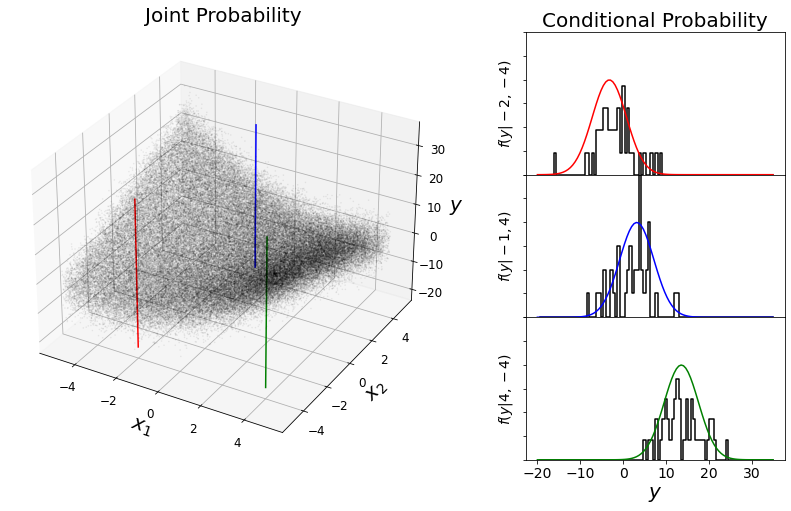

In [4]:
########  Joint Density  ########
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# sample points
x1_vals = np.random.uniform(-5, 5, 100000)
x2_vals = np.random.uniform(-5, 5, 100000)
y_vals = [sample_cond_dens(x1, x2) for x1, x2 in zip(x1_vals, x2_vals)]

# histogram of sample points
x_range = np.linspace(-5,5,51)x_range = np.linspace(-5,5,51)
y_range = np.linspace(-20,35,101)
H, edges = np.histogramdd([x1_vals, x2_vals, y_vals], bins=[x_range, x_range, y_range])
H /= np.sum(H)

ax.scatter(x1_vals, x2_vals, y_vals, color='k', s=0.5, alpha=0.05)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_zlabel('$y$', fontsize=20)
ax.plot([-2,-2], [-4,-4], [-20,30], '-r')
ax.plot([-1,-1], [4,4], [-20,30], '-b')
ax.plot([4,4], [-4,-4], [-20,30], '-g')
ax.tick_params(axis='both', which='major', labelsize=12)

########  Conditional Density  ########
ax_Px_y = [plt.axes((1.2, 0.66, 0.6, 0.33)),
           plt.axes((1.2, 0.33, 0.6, 0.33)),
           plt.axes((1.2, 0.0, 0.6, 0.33))]
ax_Px_y[0].xaxis.set_major_formatter(NullFormatter())
ax_Px_y[1].xaxis.set_major_formatter(NullFormatter())

colors = 'rbg'
x1 = [-2,-1,4]
x2 = [-4,4,-4]
x1_space = [15,20,45]
x2_space = [5,45,5]
for i in range(3):
    # sample points
    Px_y = H[x1_space[i], x2_space[i]] / H[x1_space[i], x2_space[i]].sum()
    ax_Px_y[i].plot(y_range[1:], Px_y, drawstyle='steps', c='k')
    
    # real density
    dist = calc_cond_dist(x1[i], x2[i])
    cond_probs = [dist.pdf(y) for y in y_range]
    ax_Px_y[i].plot(y_range, cond_probs, c=colors[i])
   
    ax_Px_y[i].set_ylabel('$f(y | %s, %s)$' % (x1[i], x2[i]), fontsize=14)
    ax_Px_y[i].yaxis.set_major_formatter(NullFormatter())
    ax_Px_y[i].set_ylim(ymin=0, ymax=0.15)
ax_Px_y[2].set_xlabel('$y$', fontsize=20)
plt.xticks(fontsize=14)

ax.set_title('Joint Probability', fontsize=20)
ax_Px_y[0].set_title('Conditional Probability', fontsize=20)

plt.show()

# fit correct NNKCDE

In [7]:
cutoff_idx = 60000
x_train = np.array([[x1,x2] for x1,x2 in zip(x1_vals[:cutoff_idx], x2_vals[:cutoff_idx])])
x_test = np.array([[x1,x2] for x1,x2 in zip(x1_vals[cutoff_idx:], x2_vals[cutoff_idx:])])
z_train = np.array(y_vals[:cutoff_idx])
z_test = np.array(y_vals[cutoff_idx:])

In [8]:
k = 50
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=x_train, z_train=z_train)

In [9]:
%%time

n_grid = 101
bandwidth = 0.5
z_grid = np.linspace(-20, 35, n_grid)

cde_test = model.predict(x_test, z_grid, bandwidth=bandwidth)

Wall time: 10.6 s


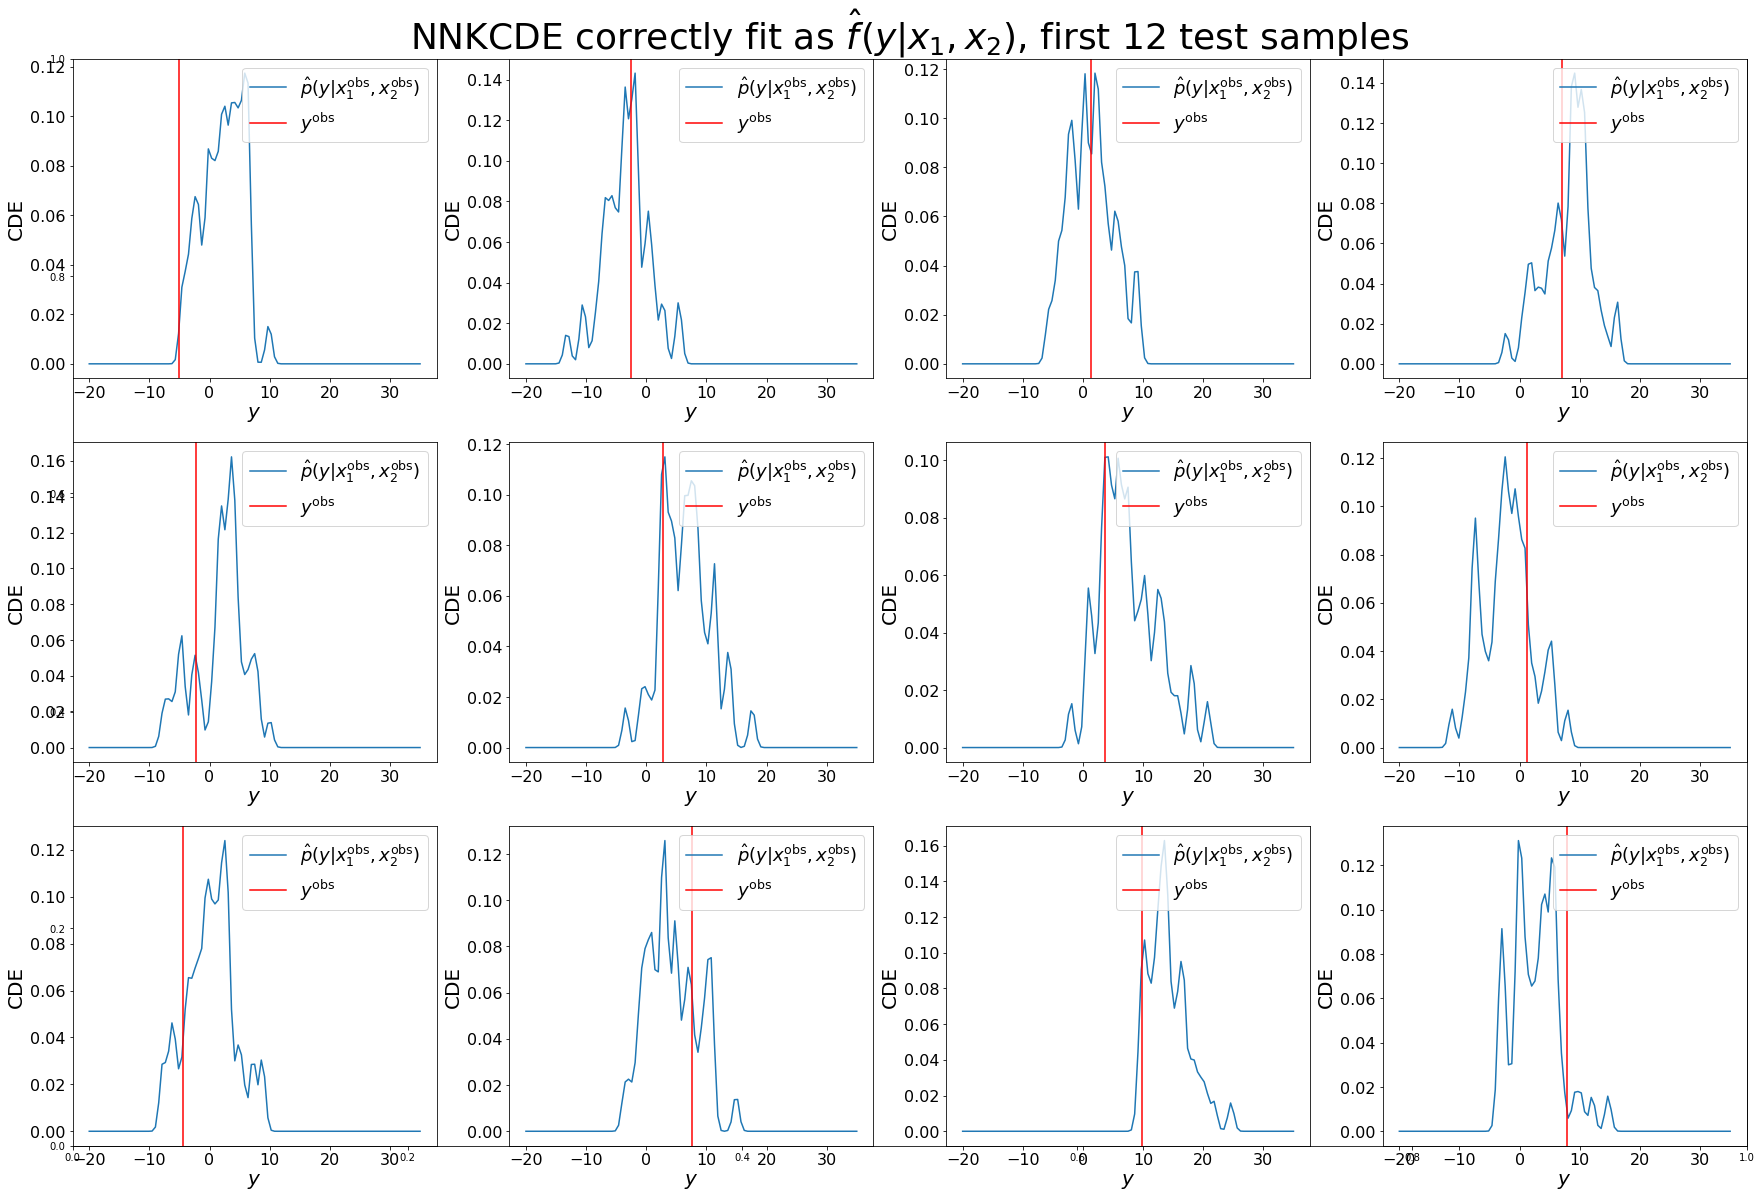

In [225]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE correctly fit as $\hat f(y|x_1,x_2)$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [11]:
print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


# fit incorrect NNKCDEs

In [12]:
cutoff_idx = 60000
x1_train = np.array(x1_vals[:cutoff_idx])
x1_test = np.array(x1_vals[cutoff_idx:])
x2_train = np.array(x2_vals[:cutoff_idx])
x2_test = np.array(x2_vals[cutoff_idx:])
z_train = np.array(y_vals[:cutoff_idx])
z_test = np.array(y_vals[cutoff_idx:])

In [13]:
k = 50
model_x1 = nnkcde.NNKCDE(k=k)
model_x1.fit(x_train=x1_train, z_train=z_train)
model_x2 = nnkcde.NNKCDE(k=k)
model_x2.fit(x_train=x2_train, z_train=z_train)

In [14]:
n_grid = 101
bandwidth = 0.5
z_grid = np.linspace(-20, 35, n_grid)

In [15]:
%%time

cde_test_x1 = model_x1.predict(x1_test, z_grid, bandwidth=bandwidth)

Wall time: 10.7 s


In [16]:
%%time

cde_test_x2 = model_x2.predict(x2_test, z_grid, bandwidth=bandwidth)

Wall time: 10.8 s


In [17]:
model_marg = sm.nonparametric.KDEUnivariate(z_train)
model_marg.fit(bw=0.5, fft=True)
cde_test_marg = model_marg.evaluate(z_grid)

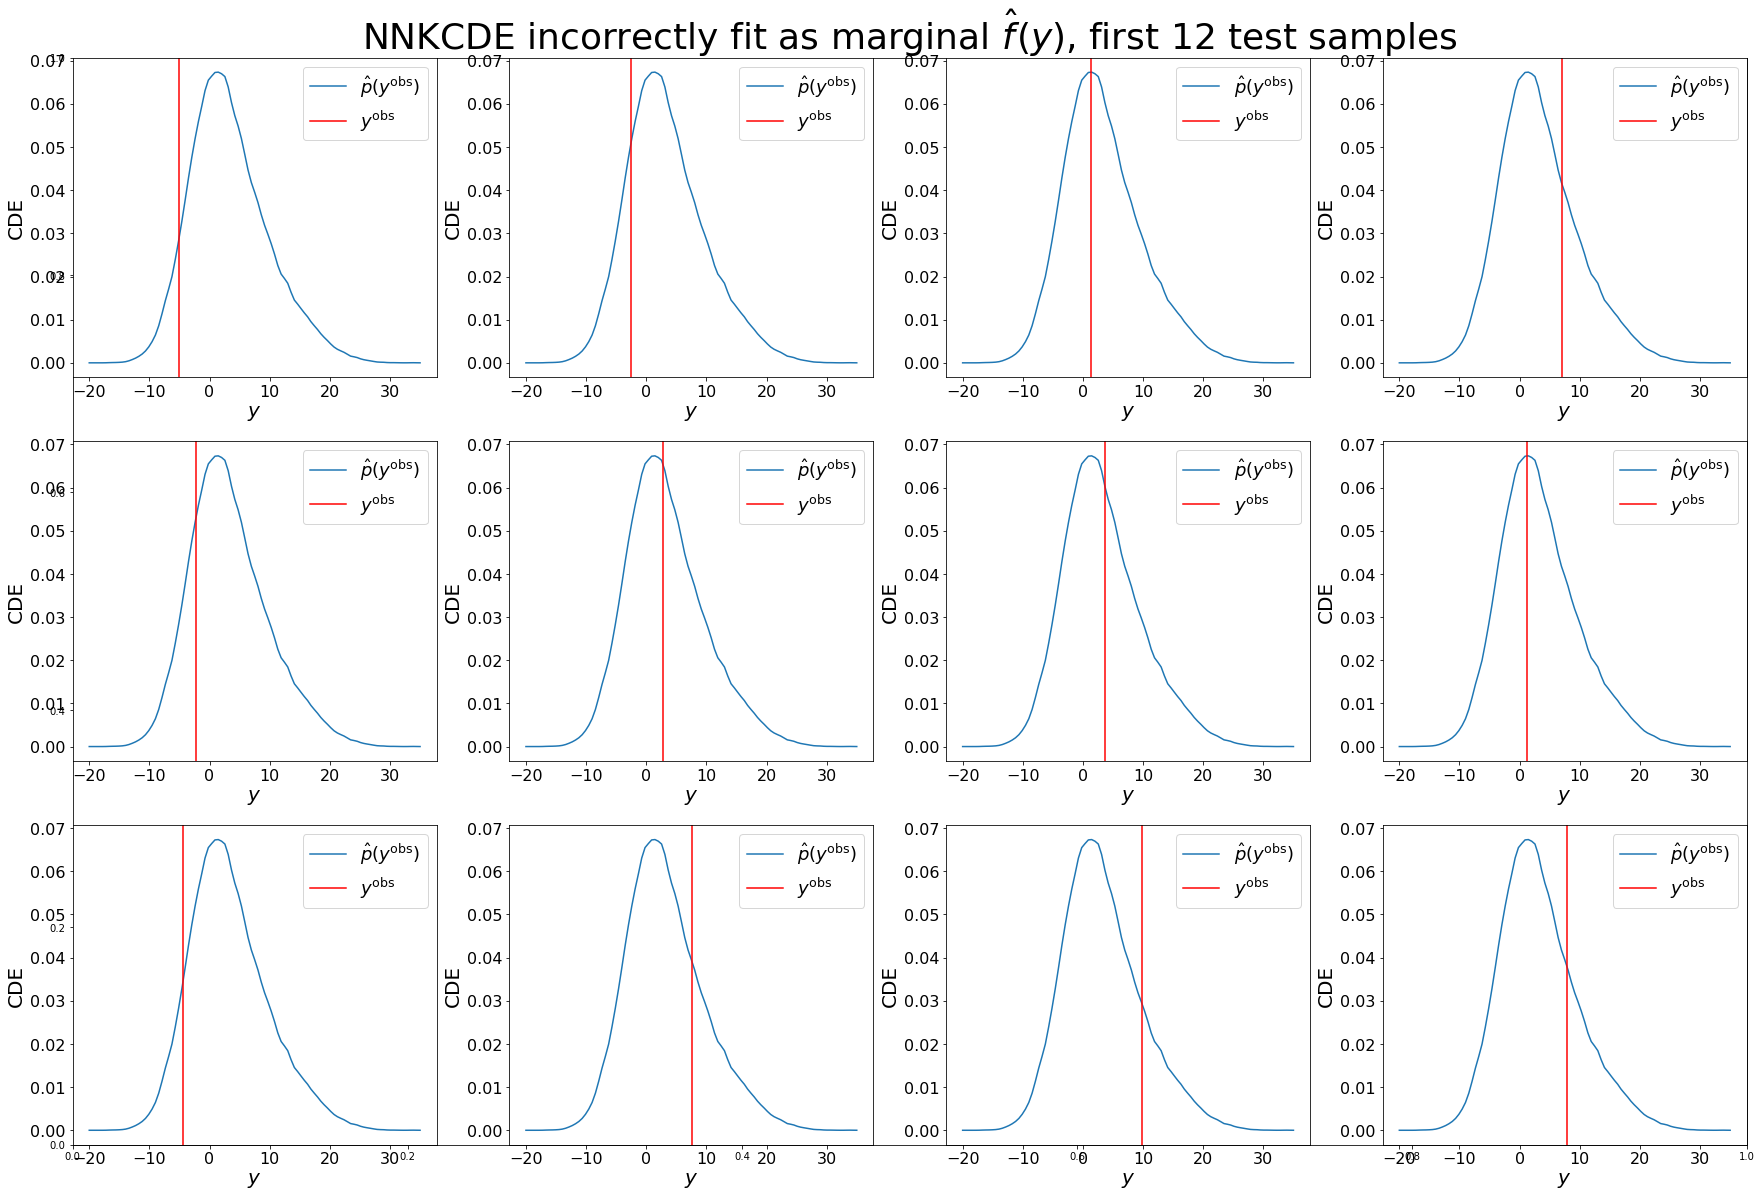

In [226]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE incorrectly fit as marginal $\hat f(y)$, first 12 test samples", fontsize=36)
for jj in range(12):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_test_marg, label=r'$\hat{p}(y^{\rm obs})$')
    plt.axvline(z_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [19]:
print(type(cde_test_x1), cde_test_x1.shape)

den_integral = simps(cde_test_x1[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


In [20]:
print(type(cde_test_x2), cde_test_x2.shape)

den_integral = simps(cde_test_x2[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


In [21]:
print(type(cde_test_marg), cde_test_marg.shape)

den_integral = simps(cde_test_marg, x=z_grid)
print('Integral of the marginal density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (101,)
Integral of the marginal density integrates to: 1.00


# PIT uniformity test: all NNKCDEs pass

In [56]:
pit_values = cdf_coverage(cde_test, z_grid, z_test)
pit_values_x1 = cdf_coverage(cde_test_x1, z_grid, z_test)
pit_values_x2 = cdf_coverage(cde_test_x2, z_grid, z_test)
pit_values_marg = cdf_coverage(np.tile(cde_test_marg, 40000).reshape(40000, 101), z_grid, z_test)

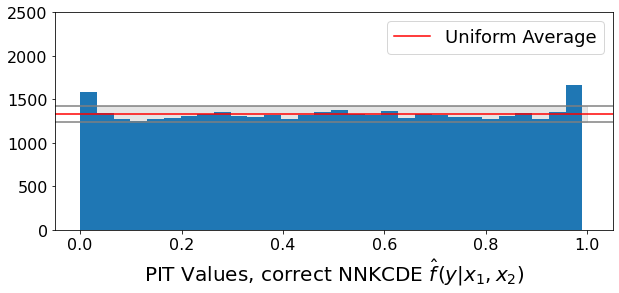

In [72]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.99, x_label='PIT Values, correct NNKCDE $\hat f(y|x_1,x_2)$', n_bins=30, ylim=[0, 2500])
fig_pit

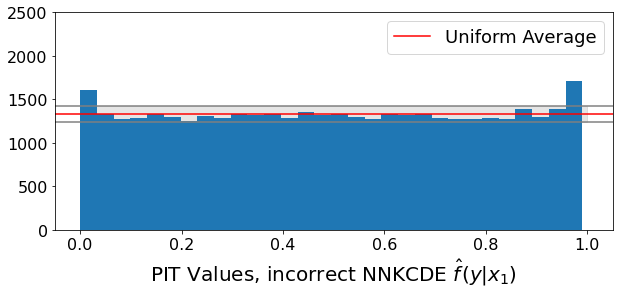

In [73]:
fig_pit = plot_with_uniform_band(values=pit_values_x1, ci_level=0.99, x_label='PIT Values, incorrect NNKCDE $\hat f(y|x_1)$', n_bins=30, ylim=[0, 2500])
fig_pit

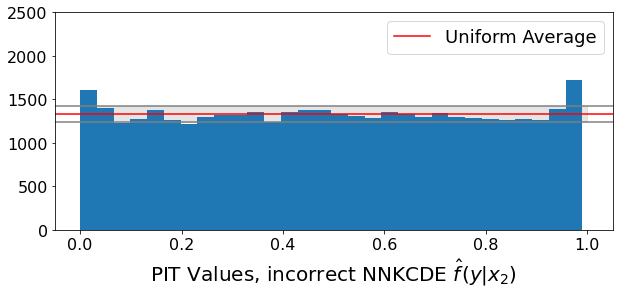

In [451]:
fig_pit = plot_with_uniform_band(values=pit_values_x2, ci_level=0.99, x_label='PIT Values, incorrect NNKCDE $\hat f(y|x_2)$', n_bins=30, ylim=[0, 2500])
fig_pit

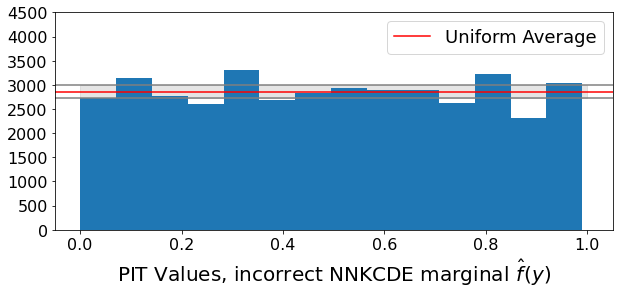

In [82]:
fig_pit = plot_with_uniform_band(values=pit_values_marg, ci_level=0.99, x_label='PIT Values, incorrect NNKCDE marginal $\hat f(y)$', n_bins=14, ylim=[0, 4500])
fig_pit

# for confidence sets

In [623]:
def get_confidence_band_range(n_trials=100, name='x1x2', alpha=0.05, points=[[1,2]]):
    sample = [1 - all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\alpha$, coverage heatmap

In [631]:
alpha = 0.2

In [162]:
x_range = np.linspace(-5,5,51)
x1, x2 = np.meshgrid(x_range, x_range)
grid = np.hstack([x1.ravel().reshape(-1,1), x2.ravel().reshape(-1,1)])
x_range_round = [round(x,1) for x in x_range]

In [163]:
ind_pit_values = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit_values]
ind_pit_values_x1 = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit_values_x1]
ind_pit_values_x2 = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit_values_x2]
ind_pit_values_marg = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit_values_marg]

In [164]:
rhat_alpha = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha.fit(X=x_test, y=ind_pit_values)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [202]:
rhat_alpha_x1 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x1.fit(X=x_test, y=ind_pit_values_x1)

rhat_alpha_x2 = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_x2.fit(X=x_test, y=ind_pit_values_x2)

rhat_alpha_marg = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_marg.fit(X=x_test, y=ind_pit_values_marg)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [203]:
alpha_pred = rhat_alpha.predict_proba(grid)[:, 1]
alpha_pred_x1 = rhat_alpha_x1.predict_proba(grid)[:, 1]
alpha_pred_x2 = rhat_alpha_x2.predict_proba(grid)[:, 1]
alpha_pred_marg = rhat_alpha_marg.predict_proba(grid)[:, 1]

In [548]:
"""
X_test_logit = sm.add_constant(x_test)
grid_logit = sm.add_constant(grid)

rhat_logit = sm.Logit(endog=ind_pit_values, exog=X_test_logit).fit(disp=0)
rhat_logit_x1 = sm.Logit(endog=ind_pit_values_x1, exog=X_test_logit).fit(disp=0)
rhat_logit_x2 = sm.Logit(endog=ind_pit_values_x2, exog=X_test_logit).fit(disp=0)
rhat_logit_marg = sm.Logit(endog=ind_pit_values_marg, exog=X_test_logit).fit(disp=0)
"""

In [554]:
"""
alpha_logit_pred = rhat_logit.predict(grid_logit)
alpha_logit_pred_x1 = rhat_logit_x1.predict(grid_logit)
alpha_logit_pred_x2 = rhat_logit_x2.predict(grid_logit)
alpha_logit_pred_marg = rhat_logit_marg.predict(grid_logit)
"""

In [633]:
confidence_fixedalpha = {}
confidence_fixedalpha['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])
confidence_fixedalpha['x1'] = np.array([get_confidence_band_range(name='x1', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['x2'] = np.array([get_confidence_band_range(name='x2', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])
confidence_fixedalpha['marg'] = np.array([get_confidence_band_range(name='marg', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])

In [665]:
fixedalpha_within_null = {}
fixedalpha_within_null['x1x2'] = np.array([1 * (1 - alpha_pred[i] < confidence_fixedalpha['x1x2'][i][0]
          or 1 - alpha_pred[i] > confidence_fixedalpha['x1x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x1'] = np.array([1 * (1 - alpha_pred_x1[i] < confidence_fixedalpha['x1'][i][0]
          or 1 - alpha_pred_x1[i] > confidence_fixedalpha['x1'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['x2'] = np.array([1 * (1 - alpha_pred_x2[i] < confidence_fixedalpha['x2'][i][0]
          or 1 - alpha_pred_x2[i] > confidence_fixedalpha['x2'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['marg'] = np.array([1 * (1 - alpha_pred_marg[i] < confidence_fixedalpha['marg'][i][0]
          or 1 - alpha_pred_marg[i] > confidence_fixedalpha['marg'][i][1]) for i in range(len(alpha_pred))])

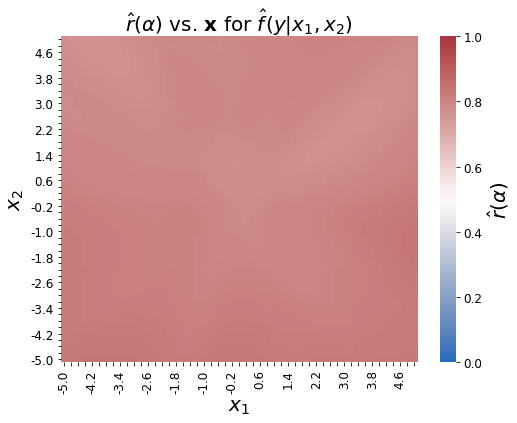

In [559]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

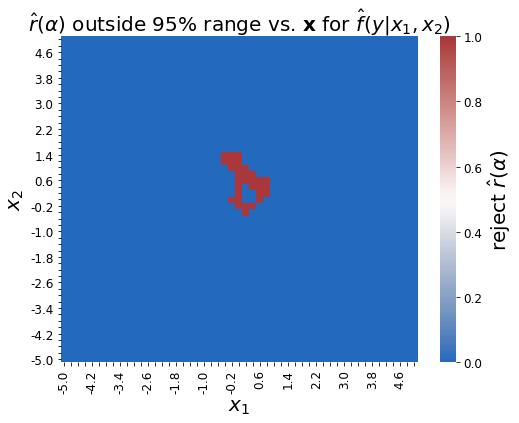

In [659]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

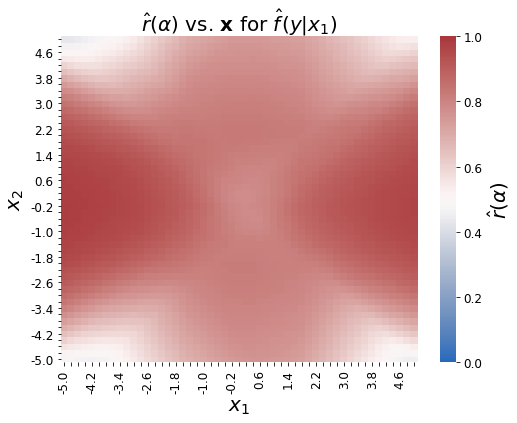

In [220]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x1.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

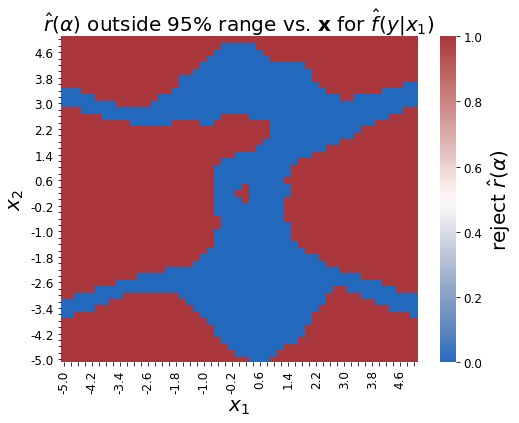

In [666]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

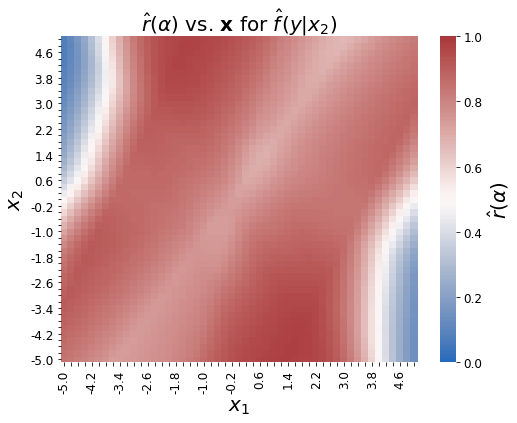

In [221]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_x2.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

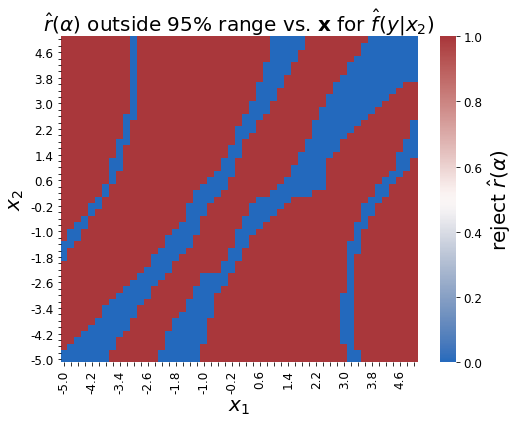

In [667]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x2'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

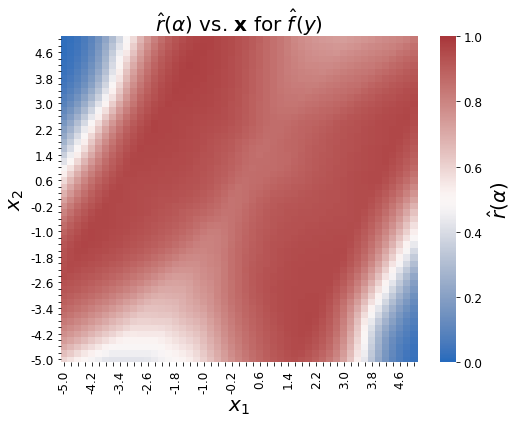

In [668]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_marg.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

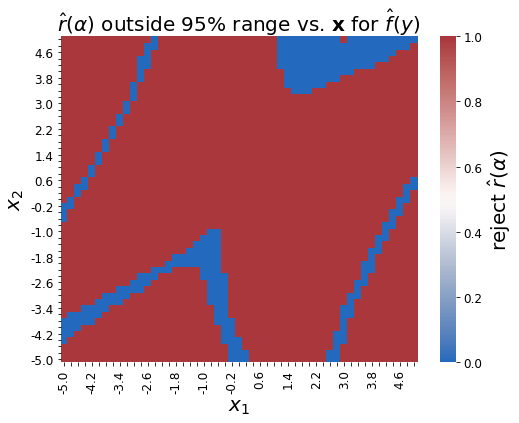

In [669]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['marg'].reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $1-\alpha$

In [541]:
x1 = 4
x2 = -4
points = np.array([[x1,x2]])
points_logit = np.array([[1,x1,x2]])

In [249]:
alphas = np.linspace(0.05, 0.95, 19)
pit_values_dict = {'x1x2': pit_values, 'x1': pit_values_x1, 'x2': pit_values_x2, 'marg': pit_values_marg}

In [250]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1][0]
rhat_alphas_xi = pd.DataFrame(rhat_alphas_xi)

working on classifier x1x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x1
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier marg
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95


In [542]:
"""
############# FOR CONFIDENCE INTERVALS #############

rhat_logit_alphas_xi = {}
rhat_logit_alphas_xi_se = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_logit_alphas_xi[name] = {}
    rhat_logit_alphas_xi_se[name] = {}
    
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit]
        rhat_logit = sm.Logit(endog=ind_values, exog=X_test_logit).fit(disp=0)
        pred = rhat_logit.predict(points_logit)[0]
        rhat_logit_alphas_xi[name][alpha] = pred
        
        # standard error
        rhat_logit_alphas_xi_se[name][alpha] = np.sqrt(np.array([xx@rhat_logit.cov_params()@xx for xx in points_logit]))[0]
        
rhat_logit_alphas_xi = pd.DataFrame(rhat_logit_alphas_xi)
rhat_logit_alphas_xi_se = pd.DataFrame(rhat_logit_alphas_xi_se)
"""

working on classifier x1x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x1
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier marg
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95


In [257]:
rhat_oneminusalphas_xi = 1 - rhat_alphas_xi
rhat_oneminusalphas_xi

,x1x2,x1,x2,marg
0.05,0.051065,0.125577,0.169665,0.200315
0.10,0.113802,0.205012,0.259747,0.363917
0.15,0.160636,0.370948,0.351767,0.615809
0.20,0.214822,0.379597,0.525567,0.659632
0.25,0.279915,0.444747,0.483678,0.741159
0.30,0.306639,0.563518,0.725602,0.803099
0.35,0.344076,0.562440,0.827395,0.889017
0.40,0.375266,0.650676,0.886015,0.864606
0.45,0.466640,0.653741,0.913773,0.907151
0.50,0.546122,0.763007,0.929172,0.927240


In [536]:
"""
rhat_logit_oneminusalphas_xi = 1 - rhat_logit_alphas_xi
rhat_logit_oneminusalphas_xi
"""

,x1x2,x1,x2,marg
0.05,0.058120,0.064210,0.065158,0.070871
0.10,0.106356,0.107538,0.116643,0.108868
0.15,0.154982,0.153958,0.163841,0.167639
0.20,0.197695,0.208777,0.216416,0.214359
0.25,0.242857,0.263241,0.262155,0.251471
0.30,0.290806,0.317612,0.309717,0.301284
0.35,0.339278,0.362777,0.354281,0.354158
0.40,0.388635,0.418706,0.404362,0.394824
0.45,0.436510,0.464017,0.452899,0.444368
0.50,0.489926,0.511900,0.498517,0.517410


In [616]:
confidence_qqplot = {}
confidence_qqplot['x1x2'] = np.array([get_confidence_band_range(name='x1x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['x1'] = np.array([get_confidence_band_range(name='x1', alpha=i, points=points) for i in alphas])
confidence_qqplot['x2'] = np.array([get_confidence_band_range(name='x2', alpha=i, points=points) for i in alphas])
confidence_qqplot['marg'] = np.array([get_confidence_band_range(name='marg', alpha=i, points=points) for i in alphas])

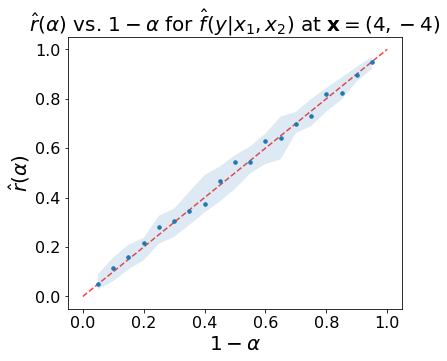

In [617]:
rhat_oneminusalphas_xi['x1x2'].plot(style='.', figsize=(6,5), markersize=7)
#ax = rhat_oneminusalphas_xi['x1x2'].plot(style='.', yerr=rhat_logit_alphas_xi_se['x1x2'], capsize=4,
#                                         ls='none', figsize=(6,5))

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# confidence bands
plt.fill_between(rhat_oneminusalphas_xi['x1x2'].index,
                 confidence_qqplot['x1x2'][:, 0],
                 confidence_qqplot['x1x2'][:, 1],
                 alpha=0.15
                )

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $1-$" + r'$\alpha$' + " for $\hat f(y|x_1,x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

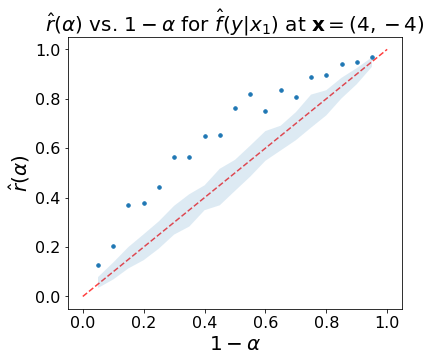

In [618]:
rhat_oneminusalphas_xi['x1'].plot(style='.', figsize=(6,5), markersize=7)
#ax = rhat_oneminusalphas_xi['x1'].plot(style='.', yerr=rhat_logit_alphas_xi_se['x1'], capsize=4,
#                                       ls='none', figsize=(6,5))

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# confidence bands
plt.fill_between(rhat_oneminusalphas_xi['x1'].index,
                 confidence_qqplot['x1'][:, 0],
                 confidence_qqplot['x1'][:, 1],
                 alpha=0.15
                )

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $1-$" + r'$\alpha$' + " for $\hat f(y|x_1)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

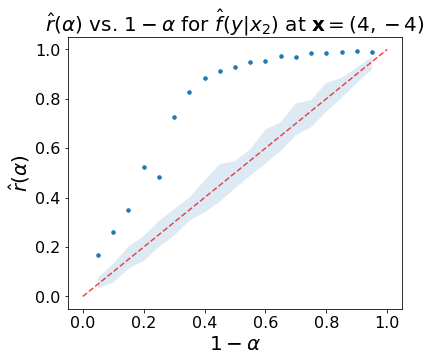

In [619]:
rhat_oneminusalphas_xi['x2'].plot(style='.', figsize=(6,5), markersize=7)
#ax = rhat_oneminusalphas_xi['x2'].plot(style='.', yerr=rhat_logit_alphas_xi_se['x2'], capsize=4,
#                                       ls='none', figsize=(6,5))


lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# confidence bands
plt.fill_between(rhat_oneminusalphas_xi['x2'].index,
                 confidence_qqplot['x2'][:, 0],
                 confidence_qqplot['x2'][:, 1],
                 alpha=0.15
                )

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $1-$" + r'$\alpha$' + " for $\hat f(y|x_2)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

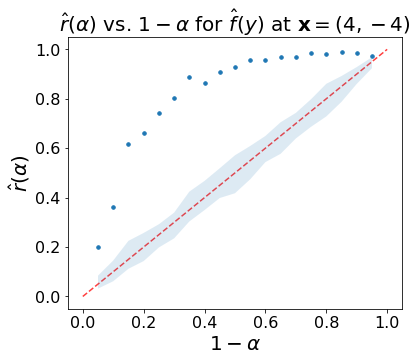

In [620]:
rhat_oneminusalphas_xi['marg'].plot(style='.', figsize=(6,5), markersize=7)
#ax = rhat_oneminusalphas_xi['marg'].plot(style='.', yerr=rhat_logit_alphas_xi_se['marg'], capsize=4,
#                                         ls='none', figsize=(6,5))

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# confidence bands
plt.fill_between(rhat_oneminusalphas_xi['marg'].index,
                 confidence_qqplot['marg'][:, 0],
                 confidence_qqplot['marg'][:, 1],
                 alpha=0.15
                )

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $1-$" + r'$\alpha$' + " for $\hat f(y)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel("$1-$" + r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - (1-\alpha))^2$

In [289]:
Ti_values = {}
all_rhat_alphas = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    all_rhat_alphas[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x >= alpha/2 and x<=1-alpha/2) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        
        # fit rhat at each point in prediction grid
        all_rhat_alphas[name][alpha] = rhat.predict_proba(grid)[:, 1]
        
    # rhat_alphas for all alphas at all points
    all_rhat_alphas[name] = pd.DataFrame(all_rhat_alphas[name])
    
    # compute Ti summary statistic
    Ti_values[name] = ((all_rhat_alphas[name] - (1-alphas))**2).sum(axis=1) / len(alphas)

working on classifier x1x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x1
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier x2
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95
working on classifier marg
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7
0.75
0.7999999999999999
0.85
0.9
0.95


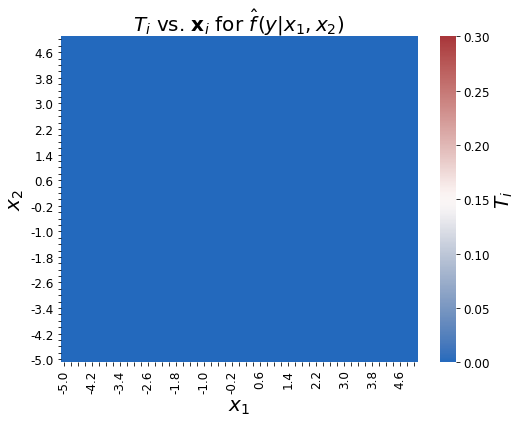

In [312]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

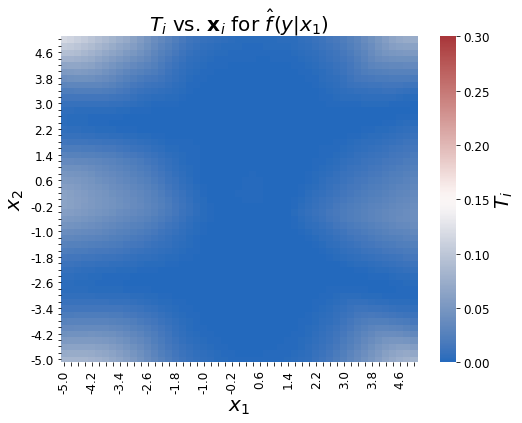

In [309]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

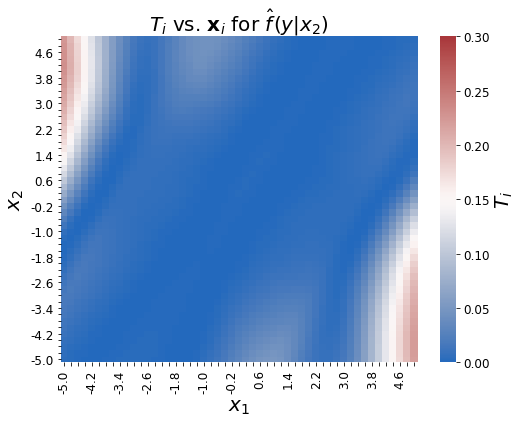

In [310]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

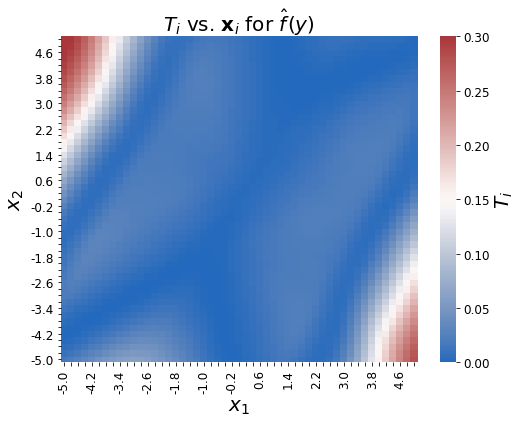

In [367]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# global p-value based on $T_i$

In [462]:
global_pvalues = sum([1* (pd.DataFrame(true_Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

x1x2    0.09
x1      0.00
x2      0.00
marg    0.00
dtype: float64

# local p-values based on $T_i$: local CvM test

In [321]:
#with open('pit_values_dict.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [325]:
#np.save('x_test.npy', x_test)

### saved $\hat r$ from MC samples, to build CIs

In [564]:
with open("all_rhat_classifiers_2021-01-26-17-03.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [568]:
all_rhat_classifiers[0]['x1x2']

{0.05: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm

In [573]:
all_rhat_classifiers[0]['x1x2'][0.05].predict_proba([[1,2]])

array([[0.04379426, 0.95620574]])

In [328]:
with open("Ti_values2021-01-17-16-41.pkl", 'rb') as handle:
    true_Ti_values = pickle.load(handle)
with open("all_unif_Ti_values2021-01-18-14-15.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [352]:
all_pvalues = sum([1* (pd.DataFrame(true_Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,x1x2,x1,x2,marg
0,0.20,0.0,0.00,0.0
1,0.21,0.0,0.00,0.0
2,0.19,0.0,0.00,0.0
3,0.20,0.0,0.01,0.0
4,0.24,0.0,0.02,0.0
...,...,...,...,...
2596,0.14,0.0,0.08,0.0
2597,0.16,0.0,0.02,0.0
2598,0.18,0.0,0.00,0.0
2599,0.20,0.0,0.00,0.0


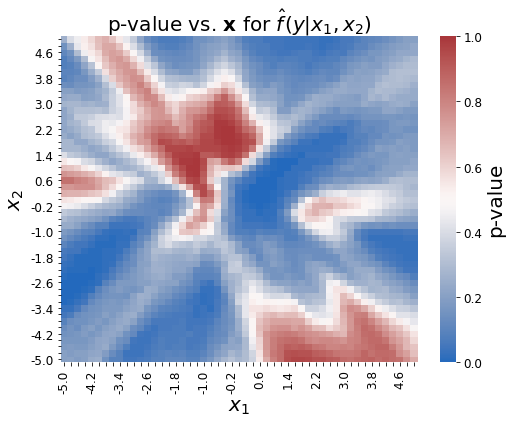

In [362]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

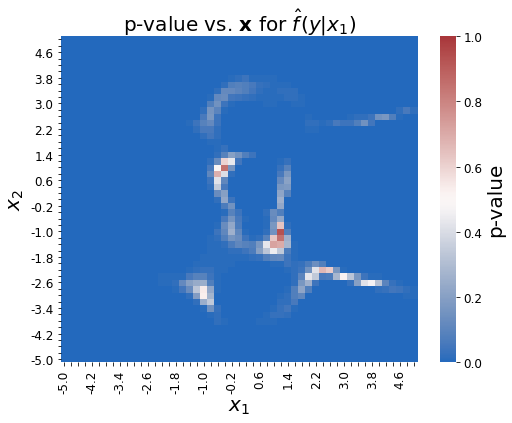

In [363]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

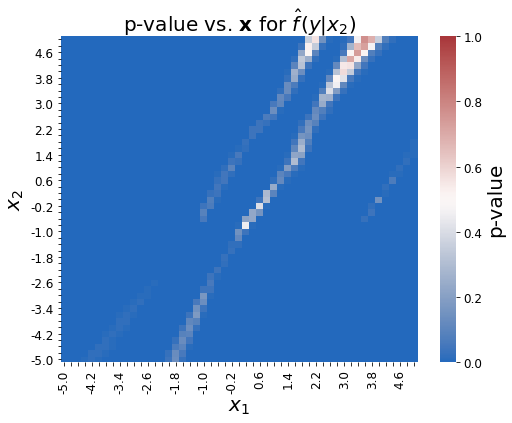

In [364]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

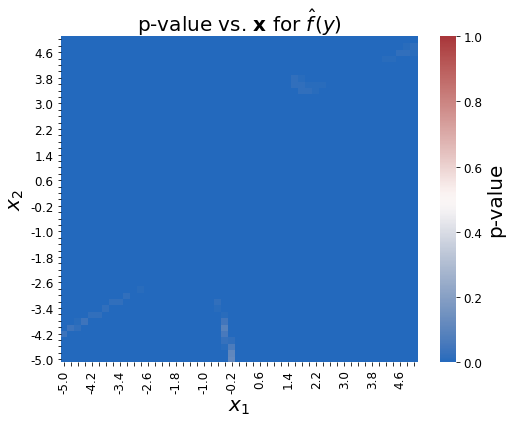

In [365]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Benjamini-Hochberg FDR correction

In [368]:
m = 51*51
alpha = 0.05

In [392]:
bh_values = alpha * (np.arange(m) + 1) / m

In [431]:
f_type = 'x1x2'
pval_vs_bh = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh.index
pval_vs_bh_sorted = pd.Series(pval_vs_bh.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_sorted == 1].index[-1]
bh_rejections = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                          index=use_idx)

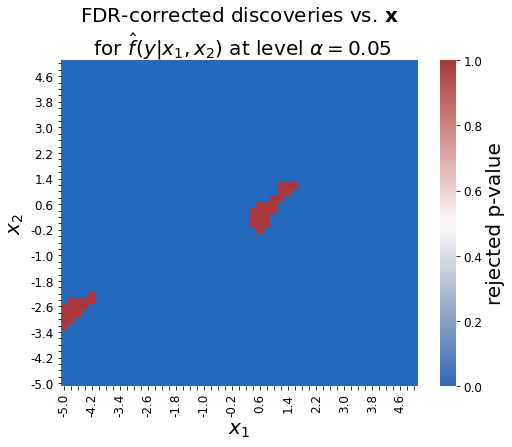

In [442]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1,x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [443]:
f_type = 'x1'
pval_vs_bh_x1 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x1.index
pval_vs_bh_x1_sorted = pd.Series(pval_vs_bh_x1.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x1_sorted == 1].index[-1]
bh_rejections_x1 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

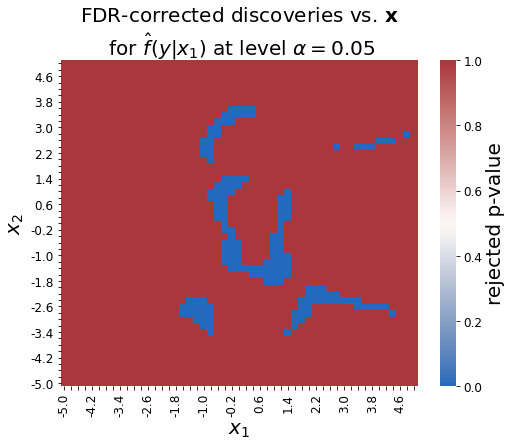

In [444]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x1.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [446]:
f_type = 'x2'
pval_vs_bh_x2 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x2.index
pval_vs_bh_x2_sorted = pd.Series(pval_vs_bh_x2.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x2_sorted == 1].index[-1]
bh_rejections_x2 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

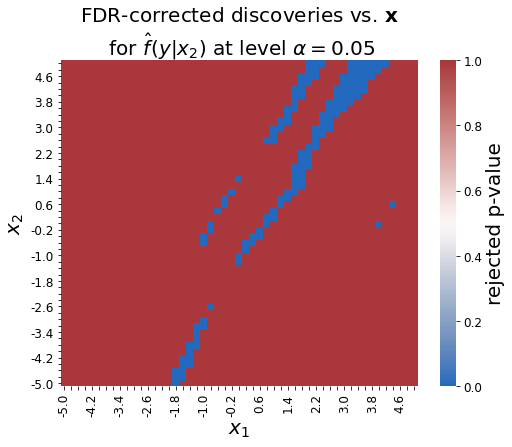

In [447]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x2.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [449]:
f_type = 'marg'
pval_vs_bh_marg = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_marg.index
pval_vs_bh_marg_sorted = pd.Series(pval_vs_bh_marg.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_marg_sorted[pval_vs_bh_marg_sorted == 1].index[-1]
bh_rejections_marg = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                               index=use_idx)

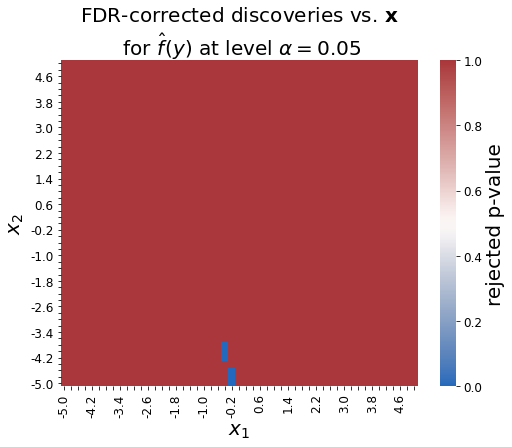

In [450]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_marg.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [ ]:
# toy example 2 --> higher dim x (e.g. simulated binary images, or Gaussian images)
# low dim y (e.g. shear and slope of line --> Rafael AISTATS example)